<a href="https://colab.research.google.com/github/Trishvan/Waiter_tip_Predection/blob/main/src.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#importing libriaries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor

import warnings
warnings.filterwarnings('ignore')


# **Synthetic data generation**

In [2]:
def generate_synthetic_data(num_samples):
    # Define feature distributions
    total_bill_dist = np.random.uniform(low=3, high=50, size=num_samples)
    tip_dist = np.random.uniform(low=1, high=15, size=num_samples)
    sex_dist = np.random.choice(['Male', 'Female'], size=num_samples)
    smoker_dist = np.random.choice(['No', 'Yes'], size=num_samples)
    day_dist = np.random.choice(['Thur', 'Fri', 'Sat', 'Sun'], size=num_samples)
    time_dist = np.random.choice(['Dinner', 'Lunch'], size=num_samples)
    size_dist = np.random.randint(1, 7, size=num_samples)

    # Create a DataFrame
    data = {'total_bill': total_bill_dist,
            'tip': tip_dist,
            'sex': sex_dist,
            'smoker': smoker_dist,
            'day': day_dist,
            'time': time_dist,
            'size': size_dist}

    df = pd.DataFrame(data)
    return df

# Generate 1000 synthetic samples
synthetic_df = generate_synthetic_data(1000)

# Print the first few rows
print(synthetic_df.head())

# Cell 2: Load the Dataset (Replace with Synthetic Data)
#data = pd.read_csv('tips.csv')
data = synthetic_df

# Display the first 5 rows
print(data.head())

   total_bill        tip     sex smoker   day    time  size
0   45.250947   9.524676  Female    Yes  Thur  Dinner     3
1   18.321820  10.889961    Male    Yes  Thur   Lunch     4
2   10.697636  10.129747  Female     No  Thur  Dinner     1
3   35.858352   3.500330  Female    Yes  Thur  Dinner     3
4   44.768576   7.158389    Male     No   Sun   Lunch     5
   total_bill        tip     sex smoker   day    time  size
0   45.250947   9.524676  Female    Yes  Thur  Dinner     3
1   18.321820  10.889961    Male    Yes  Thur   Lunch     4
2   10.697636  10.129747  Female     No  Thur  Dinner     1
3   35.858352   3.500330  Female    Yes  Thur  Dinner     3
4   44.768576   7.158389    Male     No   Sun   Lunch     5


In [4]:
data.shape

(1000, 7)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_bill  1000 non-null   float64
 1   tip         1000 non-null   float64
 2   sex         1000 non-null   object 
 3   smoker      1000 non-null   object 
 4   day         1000 non-null   object 
 5   time        1000 non-null   object 
 6   size        1000 non-null   int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 54.8+ KB


In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
total_bill,1000.0,26.200668,13.450125,3.065807,14.370215,26.048776,37.369622,49.990798
tip,1000.0,8.051633,4.021654,1.009666,4.635276,8.095416,11.557136,14.952052
size,1000.0,3.477000,1.700106,1.000000,2.000000,3.000000,5.000000,6.000000


# **Exploratory Data Analysis**

In [7]:
data.isnull().sum()

,0
total_bill,0
tip,0
sex,0
smoker,0
day,0
time,0
size,0


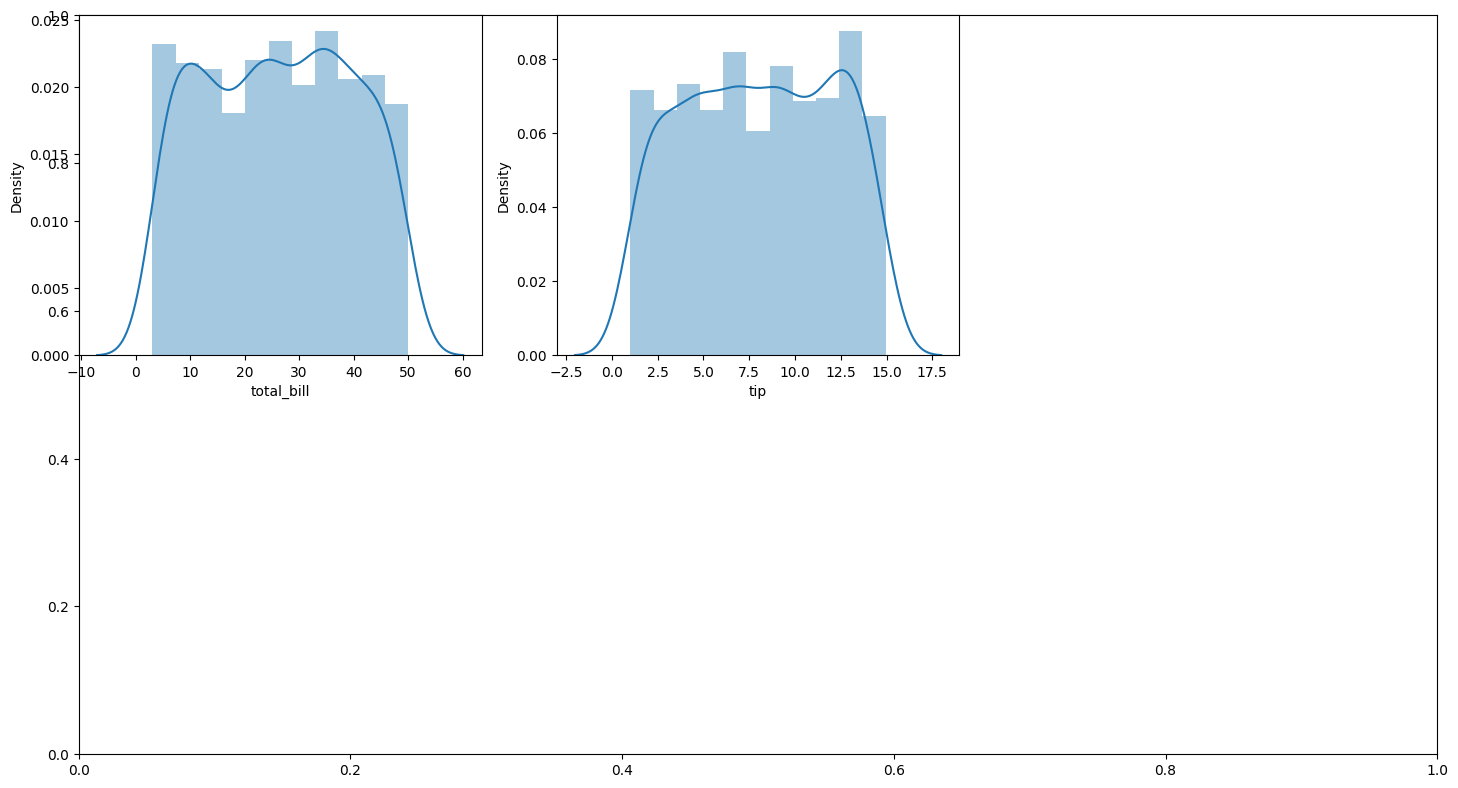

In [9]:
plt.subplots(figsize=(15,8))

for i, col in enumerate(['total_bill', 'tip']):
  plt.subplot(2,3, i + 1)
  sb.distplot(data[col])
plt.tight_layout()
plt.show()

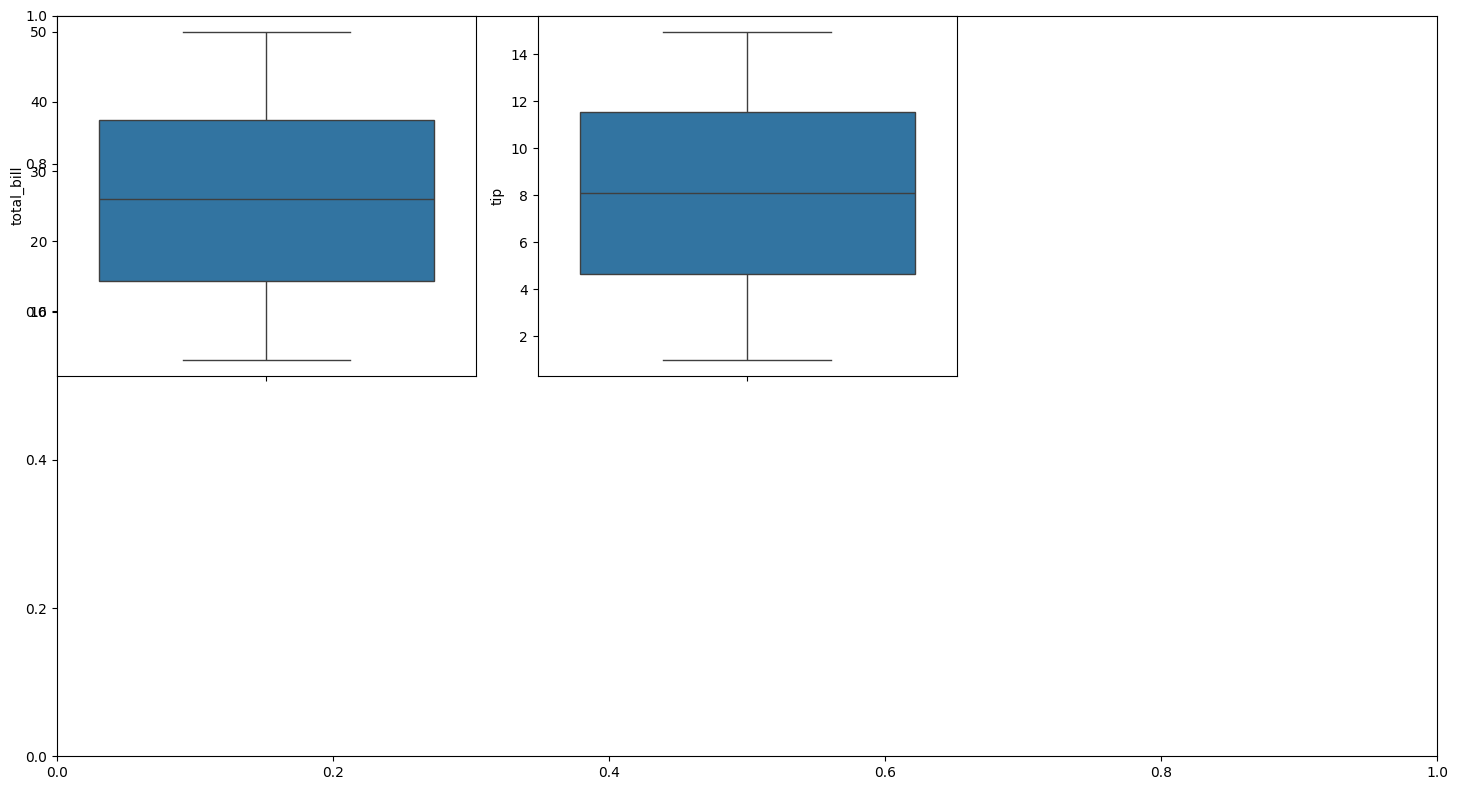

In [10]:
plt.subplots(figsize=(15,8))

for i, col in enumerate(['total_bill', 'tip']):
  plt.subplot(2,3, i + 1)
  sb.boxplot(data[col])
plt.tight_layout()
plt.show()

In [11]:
data.shape, data[(data['total_bill']<45) & (data['tip']<7)].shape

((1000, 7), (385, 7))

In [12]:
data = data[(data['total_bill']<45) & (data['tip']<7)]

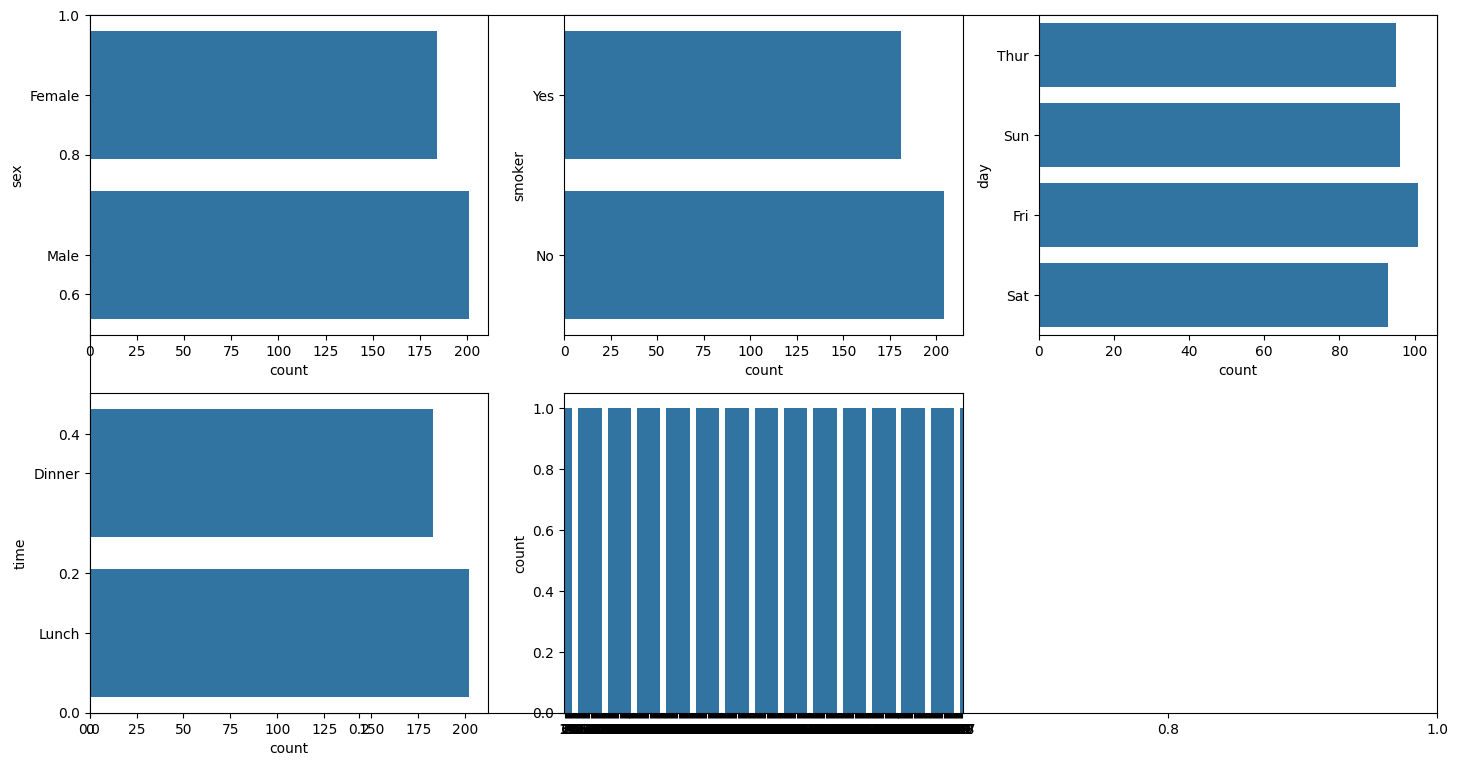

In [13]:
feat = data.loc[:,'sex':'size'].columns

plt.subplots(figsize=(15,8))
for i, col in enumerate(feat):
  plt.subplot(2,3, i + 1)
  sb.countplot(data[col])
plt.tight_layout()
plt.show()

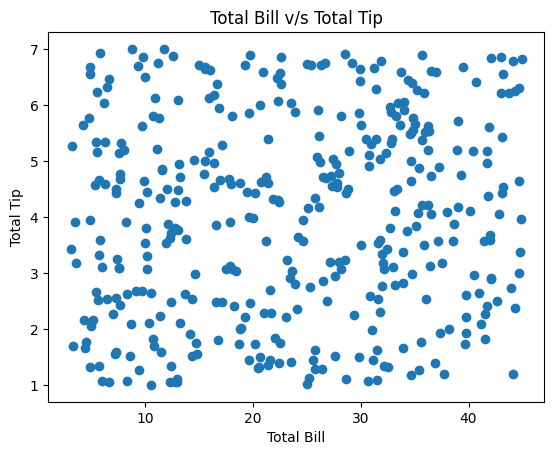

In [14]:
plt.scatter(data['total_bill'], data['tip'])
plt.title('Total Bill v/s Total Tip')
plt.xlabel('Total Bill')
plt.ylabel('Total Tip')
plt.show()

In [15]:
# set numeric_only parameter to True to avoid calculating the mean of non-numeric columns
data.groupby(['size']).mean(numeric_only=True)

# This code is modified by Susobhan Akhuli

,total_bill,tip
size,,
1,24.394266,3.726514
2,23.726572,4.007902
3,23.578436,4.012191
4,22.076404,3.981540
5,23.627291,4.231906
6,24.468804,4.050850


In [16]:
data.groupby(['time']).mean(numeric_only=True)

# This code is modified by Susobhan Akhuli

,total_bill,tip,size
time,,,
Dinner,23.212409,3.897573,3.491803
Lunch,24.007355,4.090678,3.430693


In [17]:
data.groupby(['day']).mean(numeric_only=True)

# This code is modified by Susobhan Akhuli

,total_bill,tip,size
day,,,
Fri,22.911913,4.114842,3.465347
Sat,22.105703,3.786648,3.763441
Sun,25.072432,3.979224,3.281250
Thur,24.425996,4.103263,3.336842


In [18]:
le = LabelEncoder()

for col in data.columns:
  if data[col].dtype == object:
    data[col] = le.fit_transform(data[col])

data.head()

,total_bill,tip,sex,smoker,day,time,size
3,35.858352,3.500330,0,1,3,0,3
6,24.038738,2.366519,0,1,2,1,2
7,3.065807,3.433552,0,0,3,1,3
14,16.330644,4.957441,0,1,3,0,6
17,10.744086,5.810423,0,0,2,0,4


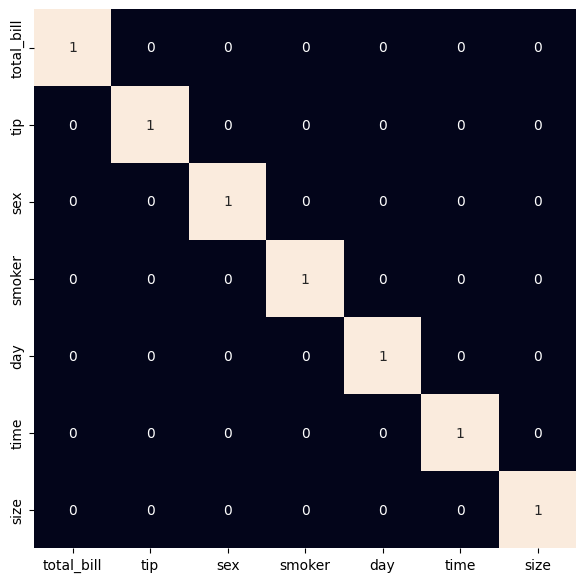

In [19]:
plt.figure(figsize=(7,7))
sb.heatmap(data.corr() > 0.7, annot = True, cbar = False)
plt.show()

# **Model selection and Training**

In [20]:
features = data.drop('tip', axis=1)
target = data['tip']

X_train, X_val, Y_train, Y_val = train_test_split(features, target, test_size=0.2, random_state=22)
X_train.shape, X_val.shape

((308, 6), (77, 6))

In [21]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [22]:
models = [LinearRegression(), XGBRegressor(), RandomForestRegressor(), AdaBoostRegressor()]

for i in range(4):
  models[i].fit(X_train, Y_train)

  print(f'{models[i]} : ')
  pred_train = models[i].predict(X_train)
  print('Training Accuracy : ', mae(Y_train, pred_train))

  pred_val = models[i].predict(X_val)
  print('Validation Accuracy : ', mae(Y_val, pred_val))
  print()


LinearRegression() : 
Training Accuracy :  1.4622546152600626
Validation Accuracy :  1.5274211828067101

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...) : 
Training Accuracy :  0.053907468498540806
Validation Accuracy :  1.9804737686691323

RandomForestRegressor() : 
Training Accuracy :  0.5655745815

In [25]:
def predict_tip():
    while True:
        try:
            total_bill = float(input("Enter the total bill amount: "))
            size = int(input("Enter the number of people: "))

            # Create a new sample with user input
            new_sample = pd.DataFrame({'total_bill': [total_bill], 'size': [size]})

            # Scale the new sample
            new_sample_scaled = scaler.transform(new_sample)

            # Predict the tip using the best model
            predicted_tip = best_model.predict(new_sample_scaled)[0]

            print(f"Predicted tip: ${predicted_tip:.2f}")
            break
        except ValueError:
            print("Invalid input. Please enter a valid number.")

# Call the prediction function
predict_tip()

Enter the total bill amount: 212
Enter the number of people: 1
Invalid input. Please enter a valid number.


KeyboardInterrupt: Interrupted by user

In [ ]:
#importing libriaries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor

import warnings
warnings.filterwarnings('ignore')


# **Synthetic data generation**

In [ ]:
def generate_synthetic_data(num_samples):
    # Define feature distributions
    total_bill_dist = np.random.uniform(low=3, high=50, size=num_samples)
    tip_dist = np.random.uniform(low=1, high=15, size=num_samples)
    sex_dist = np.random.choice(['Male', 'Female'], size=num_samples)
    smoker_dist = np.random.choice(['No', 'Yes'], size=num_samples)
    day_dist = np.random.choice(['Thur', 'Fri', 'Sat', 'Sun'], size=num_samples)
    time_dist = np.random.choice(['Dinner', 'Lunch'], size=num_samples)
    size_dist = np.random.randint(1, 7, size=num_samples)

    # Create a DataFrame
    data = {'total_bill': total_bill_dist,
            'tip': tip_dist,
            'sex': sex_dist,
            'smoker': smoker_dist,
            'day': day_dist,
            'time': time_dist,
            'size': size_dist}

    df = pd.DataFrame(data)
    return df

# Generate 1000 synthetic samples
synthetic_df = generate_synthetic_data(1000)

# Print the first few rows
print(synthetic_df.head())

# Cell 2: Load the Dataset (Replace with Synthetic Data)
#data = pd.read_csv('tips.csv')
data = synthetic_df

# Display the first 5 rows
print(data.head())

   total_bill        tip     sex smoker   day    time  size
0   45.250947   9.524676  Female    Yes  Thur  Dinner     3
1   18.321820  10.889961    Male    Yes  Thur   Lunch     4
2   10.697636  10.129747  Female     No  Thur  Dinner     1
3   35.858352   3.500330  Female    Yes  Thur  Dinner     3
4   44.768576   7.158389    Male     No   Sun   Lunch     5
   total_bill        tip     sex smoker   day    time  size
0   45.250947   9.524676  Female    Yes  Thur  Dinner     3
1   18.321820  10.889961    Male    Yes  Thur   Lunch     4
2   10.697636  10.129747  Female     No  Thur  Dinner     1
3   35.858352   3.500330  Female    Yes  Thur  Dinner     3
4   44.768576   7.158389    Male     No   Sun   Lunch     5


In [ ]:
data.shape

(1000, 7)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_bill  1000 non-null   float64
 1   tip         1000 non-null   float64
 2   sex         1000 non-null   object 
 3   smoker      1000 non-null   object 
 4   day         1000 non-null   object 
 5   time        1000 non-null   object 
 6   size        1000 non-null   int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 54.8+ KB


In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
total_bill,1000.0,26.200668,13.450125,3.065807,14.370215,26.048776,37.369622,49.990798
tip,1000.0,8.051633,4.021654,1.009666,4.635276,8.095416,11.557136,14.952052
size,1000.0,3.477000,1.700106,1.000000,2.000000,3.000000,5.000000,6.000000


# **Exploratory Data Analysis**

In [ ]:
data.isnull().sum()

,0
total_bill,0
tip,0
sex,0
smoker,0
day,0
time,0
size,0


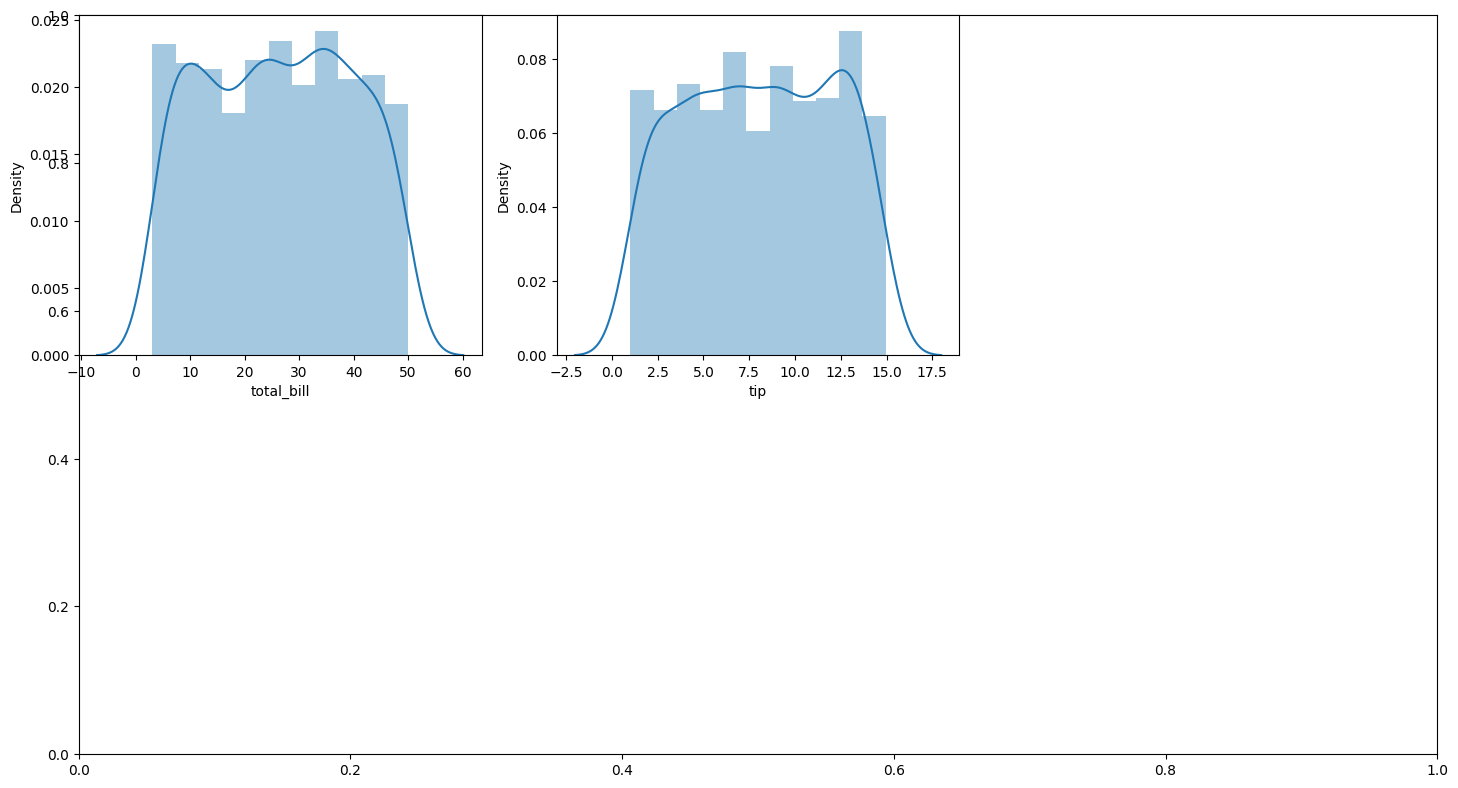

In [ ]:
plt.subplots(figsize=(15,8))

for i, col in enumerate(['total_bill', 'tip']):
  plt.subplot(2,3, i + 1)
  sb.distplot(data[col])
plt.tight_layout()
plt.show()

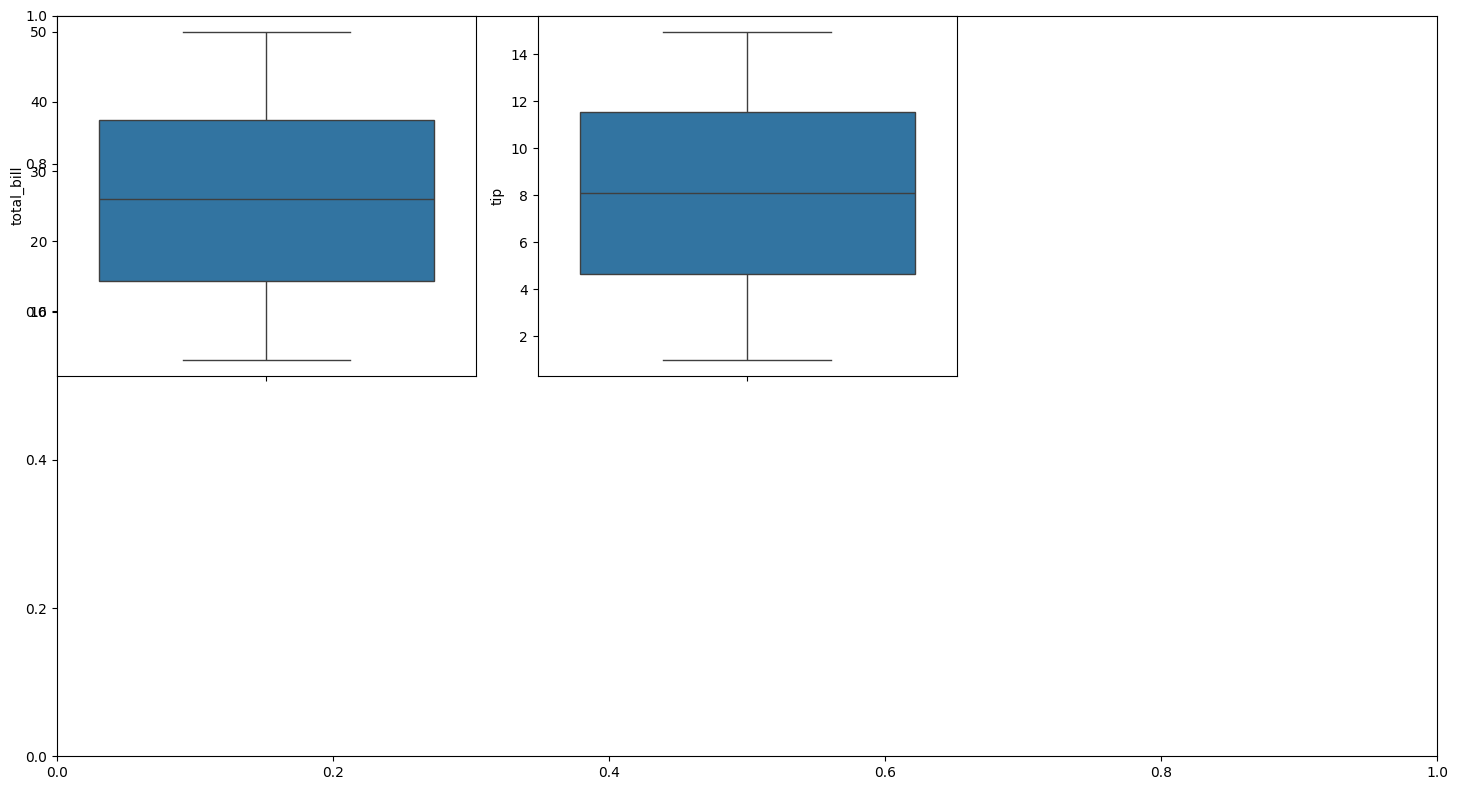

In [ ]:
plt.subplots(figsize=(15,8))

for i, col in enumerate(['total_bill', 'tip']):
  plt.subplot(2,3, i + 1)
  sb.boxplot(data[col])
plt.tight_layout()
plt.show()

In [ ]:
data.shape, data[(data['total_bill']<45) & (data['tip']<7)].shape

((1000, 7), (385, 7))

In [ ]:
data = data[(data['total_bill']<45) & (data['tip']<7)]

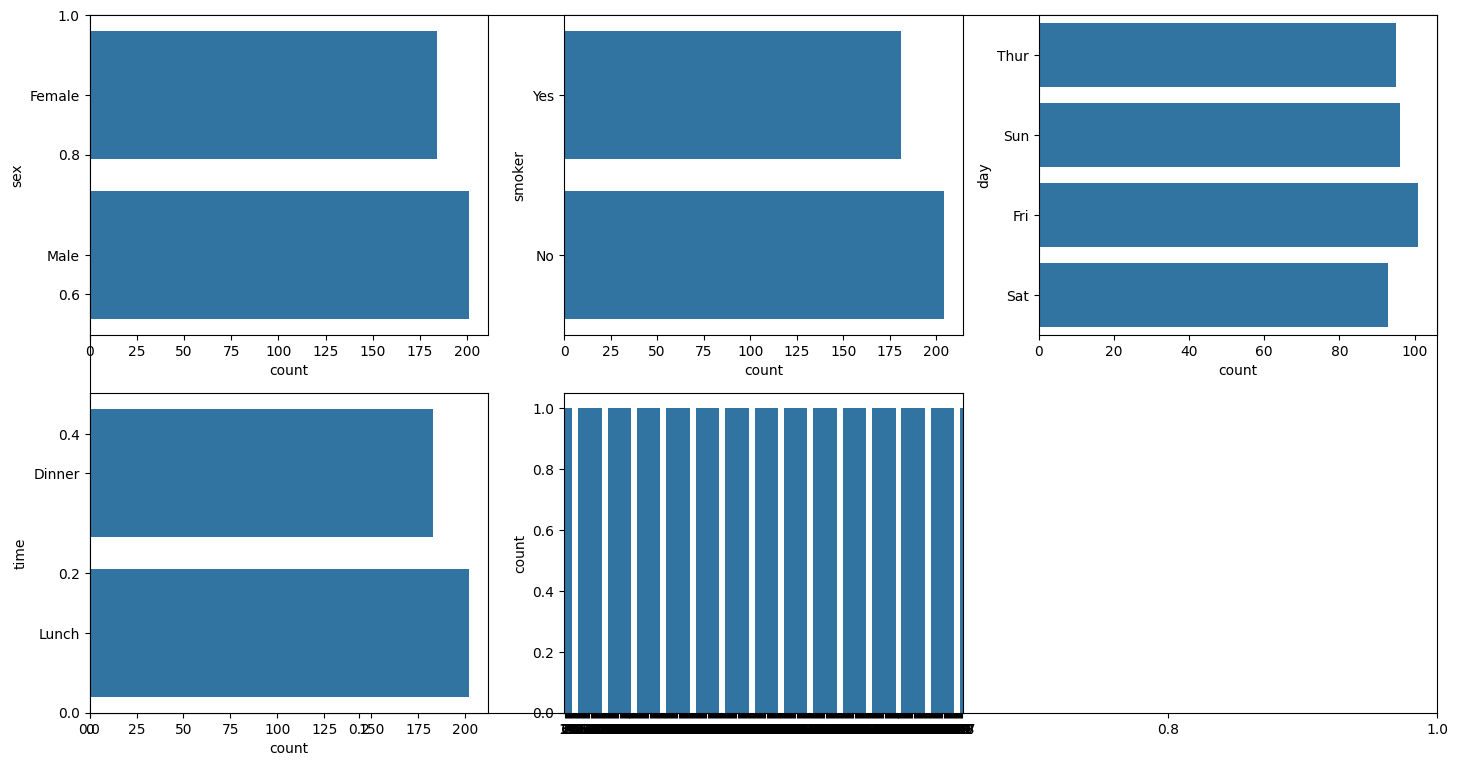

In [ ]:
feat = data.loc[:,'sex':'size'].columns

plt.subplots(figsize=(15,8))
for i, col in enumerate(feat):
  plt.subplot(2,3, i + 1)
  sb.countplot(data[col])
plt.tight_layout()
plt.show()

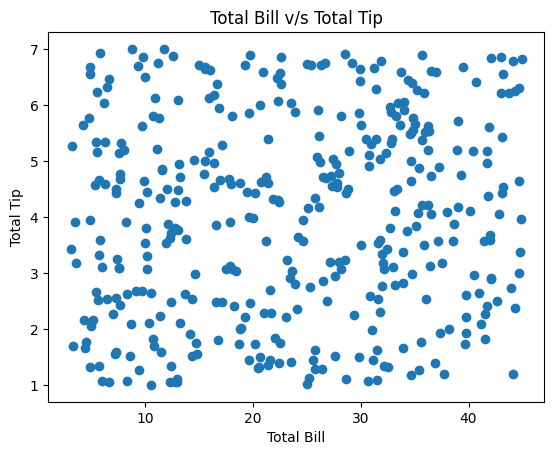

In [ ]:
plt.scatter(data['total_bill'], data['tip'])
plt.title('Total Bill v/s Total Tip')
plt.xlabel('Total Bill')
plt.ylabel('Total Tip')
plt.show()

In [ ]:
# set numeric_only parameter to True to avoid calculating the mean of non-numeric columns
data.groupby(['size']).mean(numeric_only=True)

# This code is modified by Susobhan Akhuli

,total_bill,tip
size,,
1,24.394266,3.726514
2,23.726572,4.007902
3,23.578436,4.012191
4,22.076404,3.981540
5,23.627291,4.231906
6,24.468804,4.050850


In [ ]:
data.groupby(['time']).mean(numeric_only=True)

# This code is modified by Susobhan Akhuli

,total_bill,tip,size
time,,,
Dinner,23.212409,3.897573,3.491803
Lunch,24.007355,4.090678,3.430693


In [ ]:
data.groupby(['day']).mean(numeric_only=True)

# This code is modified by Susobhan Akhuli

,total_bill,tip,size
day,,,
Fri,22.911913,4.114842,3.465347
Sat,22.105703,3.786648,3.763441
Sun,25.072432,3.979224,3.281250
Thur,24.425996,4.103263,3.336842


In [ ]:
le = LabelEncoder()

for col in data.columns:
  if data[col].dtype == object:
    data[col] = le.fit_transform(data[col])

data.head()

,total_bill,tip,sex,smoker,day,time,size
3,35.858352,3.500330,0,1,3,0,3
6,24.038738,2.366519,0,1,2,1,2
7,3.065807,3.433552,0,0,3,1,3
14,16.330644,4.957441,0,1,3,0,6
17,10.744086,5.810423,0,0,2,0,4


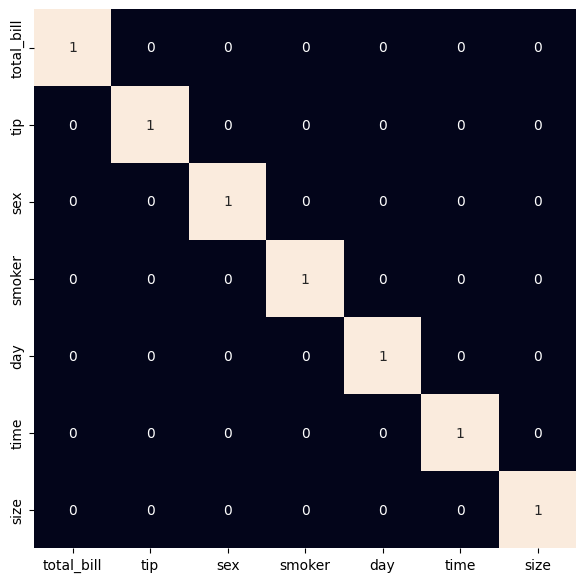

In [ ]:
plt.figure(figsize=(7,7))
sb.heatmap(data.corr() > 0.7, annot = True, cbar = False)
plt.show()

# **Model selection and Training**

In [ ]:
features = data.drop('tip', axis=1)
target = data['tip']

X_train, X_val, Y_train, Y_val = train_test_split(features, target, test_size=0.2, random_state=22)
X_train.shape, X_val.shape

((308, 6), (77, 6))

In [31]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [32]:
models = [LinearRegression(), XGBRegressor(), RandomForestRegressor(), AdaBoostRegressor()]

for i in range(4):
  models[i].fit(X_train, Y_train)

  print(f'{models[i]} : ')
  pred_train = models[i].predict(X_train)
  print('Training Accuracy : ', mae(Y_train, pred_train))

  pred_val = models[i].predict(X_val)
  print('Validation Accuracy : ', mae(Y_val, pred_val))
  print()

LinearRegression() : 
Training Accuracy :  1.4622546152600628
Validation Accuracy :  1.5274211828067101

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...) : 
Training Accuracy :  0.053907468498540806
Validation Accuracy :  1.9804737686691323

RandomForestRegressor() : 
Training Accuracy :  0.5637984408